In [2]:
#Importation des bibliothèques de base
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Importation des bibliothèques spécifiques aux séries chronologiques
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error



Données chargées depuis le fichier CSV !
La série contient 84 points de 2018-01-31 à 2024-12-31


C:\Users\zme.IGA\AppData\Local\Temp\ipykernel_7404\2062033620.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data = ts_data.asfreq('M')


,total_remboursement
mois,
2018-01-31,649497.70
2018-02-28,611153.71
2018-03-31,662224.45
2018-04-30,594021.41
2018-05-31,563939.52


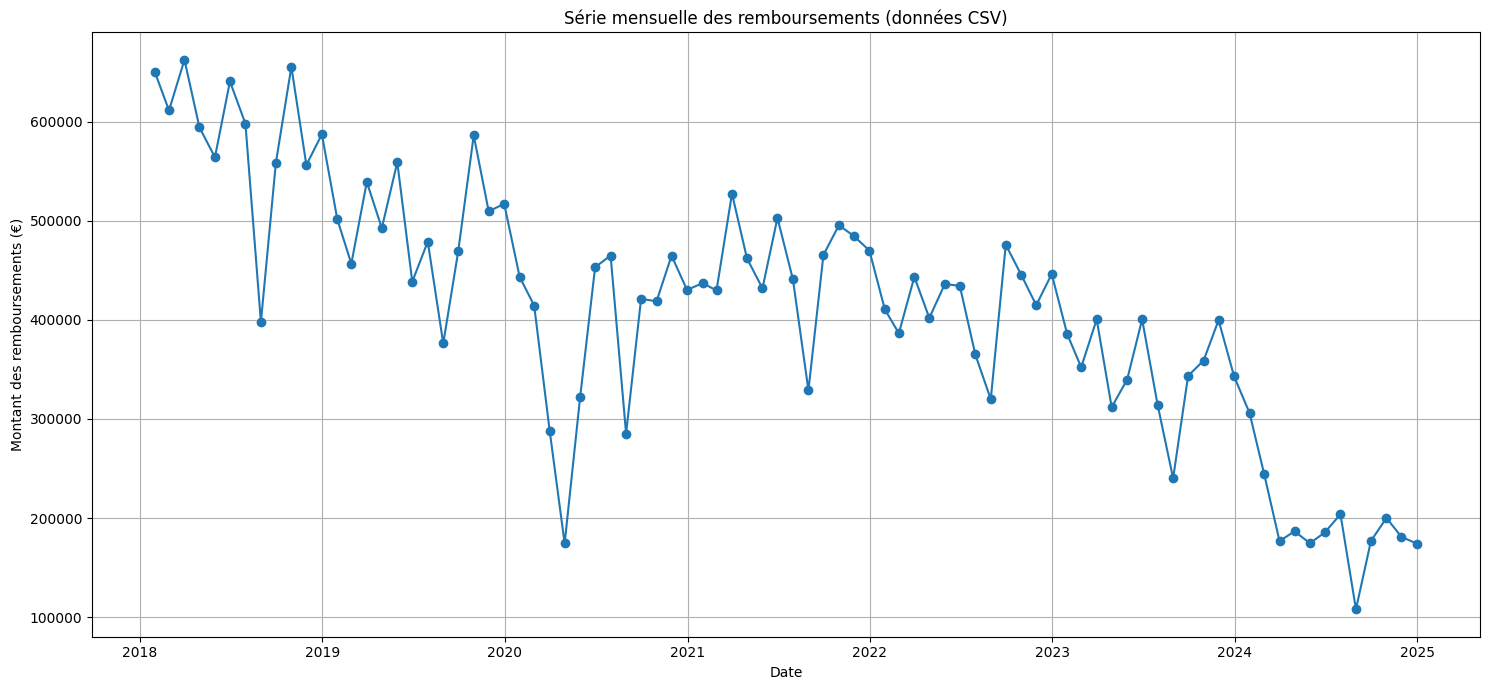

In [5]:
# --- Importations nécessaires ---
import pandas as pd
import matplotlib.pyplot as plt

# --- Chemin vers le fichier CSV ---
# Si le CSV est dans le même dossier que le notebook :
csv_path = "TestConso.csv"
# Sinon, mets le chemin complet, par ex :
# csv_path = r"C:\Users\...\TestConso.csv"

# --- Chargement des données depuis le CSV ---
try:
    # Lecture du CSV séparé par des ";"
    ts_data = pd.read_csv(
        csv_path,
        sep=';',                 # très important, ton fichier est séparé par ";"
        parse_dates=['mois'],    # convertir la colonne mois en datetime
        dayfirst=True            # car tu es au format jour/mois/année
    )

    # Mise de la colonne "mois" en index + tri par date
    ts_data = ts_data.set_index('mois').sort_index()

    # Optionnel : forcer la fréquence mensuelle pour les modèles de séries temporelles
    ts_data = ts_data.asfreq('M')

    print("Données chargées depuis le fichier CSV !")
    print(f"La série contient {len(ts_data)} points de {ts_data.index.min().date()} à {ts_data.index.max().date()}")
    display(ts_data.head())

    # --- Visualisation de la série temporelle ---
    plt.figure(figsize=(15, 7))
    plt.plot(ts_data.index, ts_data['total_remboursement'], marker='o')
    plt.title("Série mensuelle des remboursements (données CSV)")
    plt.xlabel("Date")
    plt.ylabel("Montant des remboursements (€)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Une erreur est survenue lors du chargement du CSV : {e}")


C:\Users\zme.IGA\AppData\Local\Temp\ipykernel_7404\1389410610.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_data = ts_data.asfreq('M')  # Définit la fréquence comme mensuelle


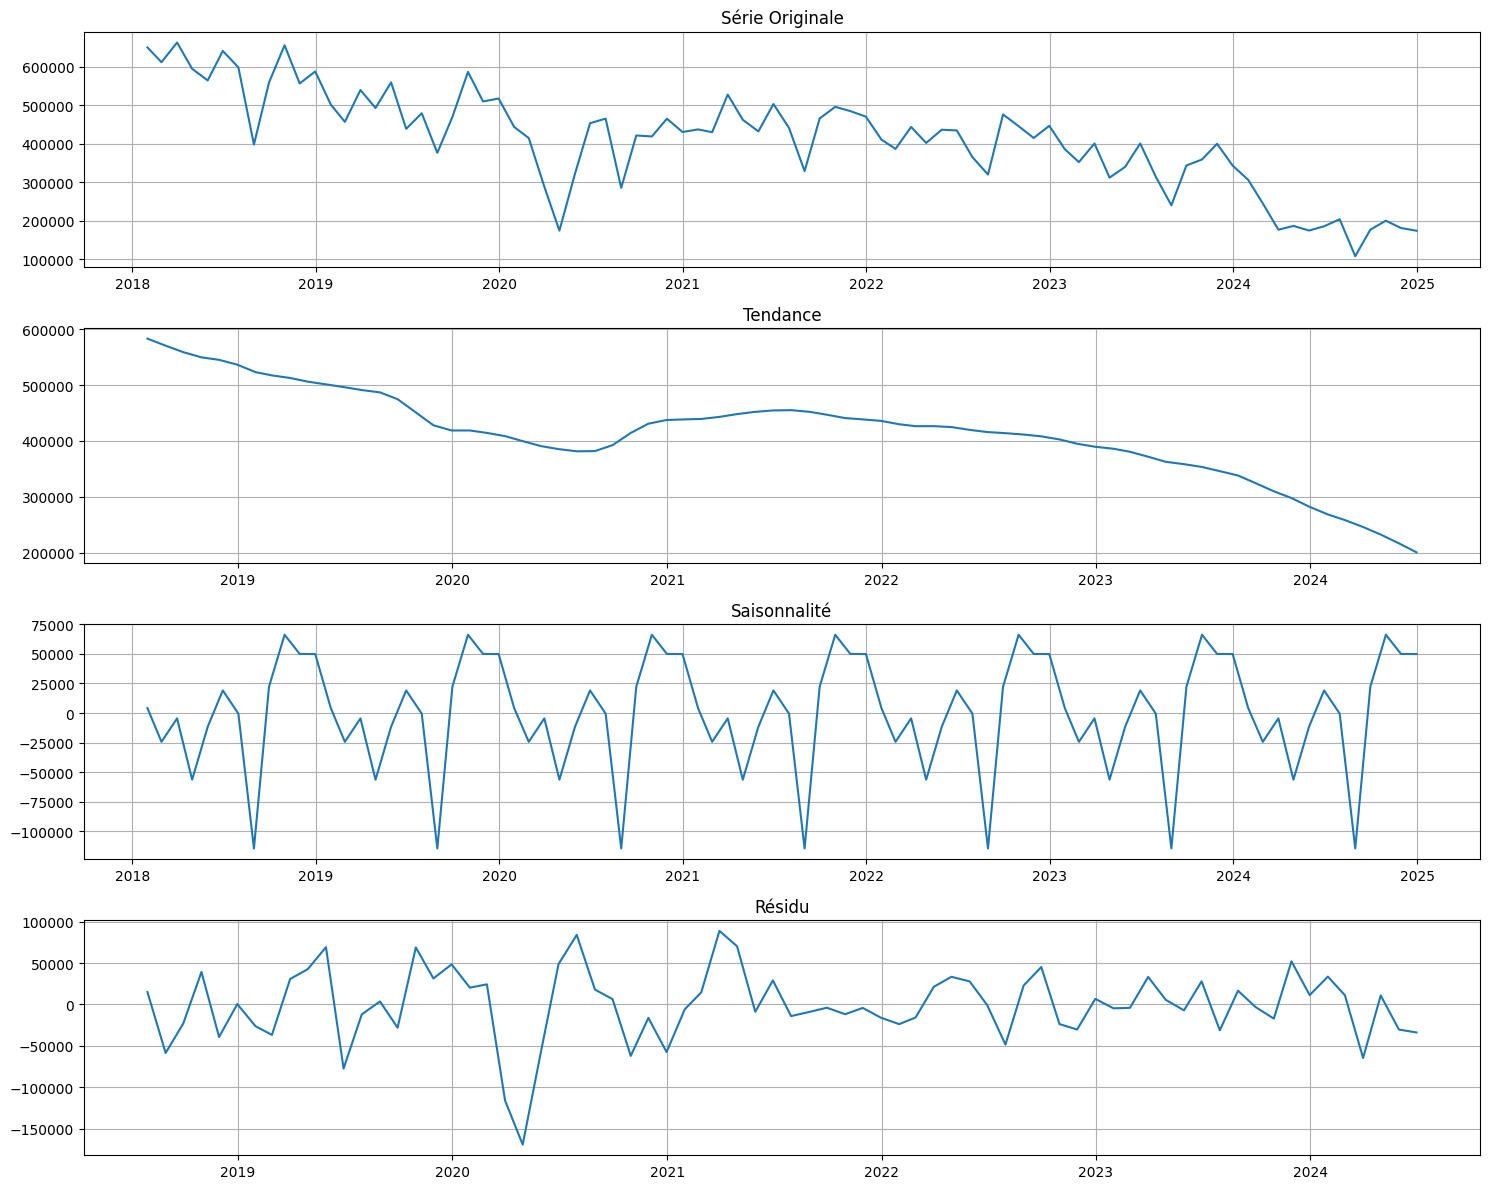

Analyse des composantes :
Amplitude de la saisonnalité : 180716.53
Variance des résidus : 1875683551.77


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assurez-vous que les données sont au format mensuel et bien indexées
ts_data = ts_data.asfreq('M')  # Définit la fréquence comme mensuelle

# Décomposition additive (vous pouvez aussi essayer multiplicative si la saisonnalité varie avec le niveau)
decomposition = seasonal_decompose(ts_data['total_remboursement'], model='additive')

# Visualisation de la décomposition
plt.figure(figsize=(15, 12))

# Série originale
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Série Originale')
plt.grid(True)

# Tendance
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Tendance')
plt.grid(True)

# Saisonnalité
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Saisonnalité')
plt.grid(True)

# Résidu
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Résidu')
plt.grid(True)

plt.tight_layout()
plt.show()

# Analyse statistique des composantes
print("Analyse des composantes :")
print(f"Amplitude de la saisonnalité : {decomposition.seasonal.max() - decomposition.seasonal.min():.2f}")
print(f"Variance des résidus : {decomposition.resid.var():.2f}")

Test de stationnarité sur la série originale:
Résultats du test de Dickey-Fuller augmenté:
Statistique de test      -1.725940
p-value                   0.417799
Lags utilisés             2.000000
Nombre d'observations    81.000000
Valeur critique (1%)     -3.513790
Valeur critique (5%)     -2.897943
Valeur critique (10%)    -2.586191
dtype: float64

Interprétation:
→ La série est NON STATIONNAIRE (on ne peut pas rejeter H0)


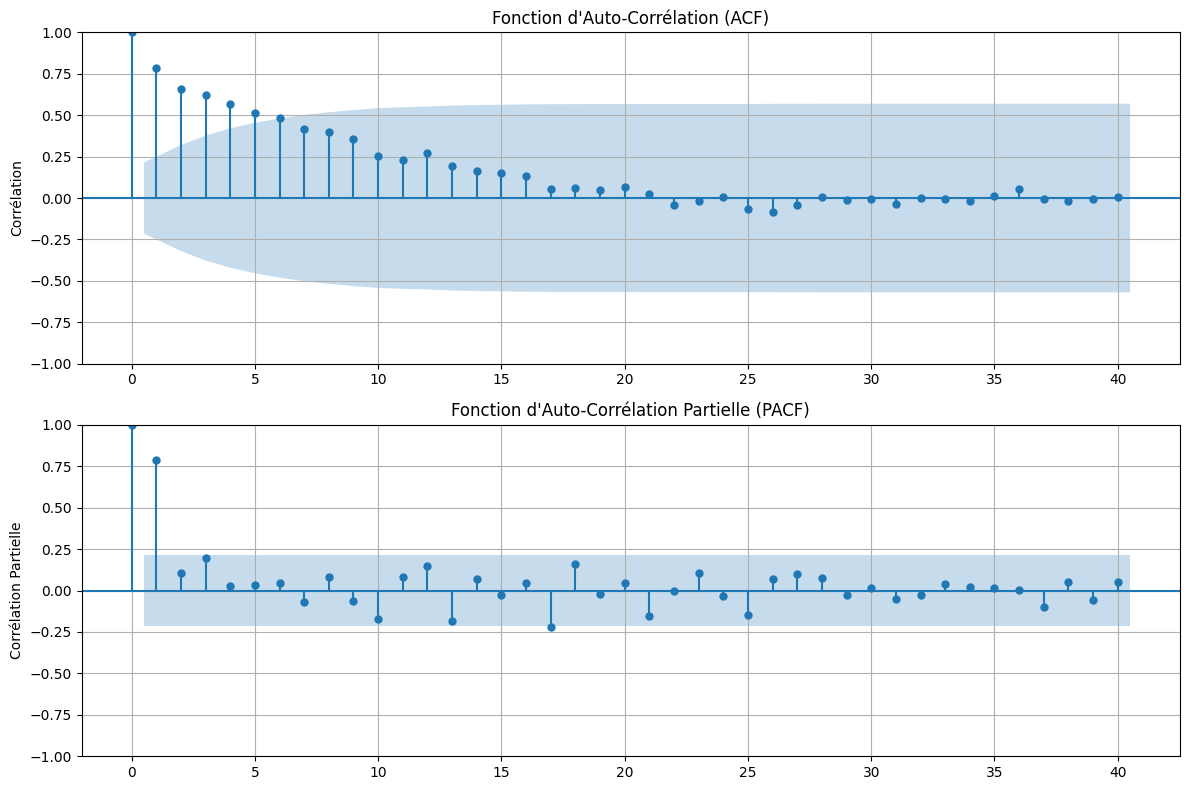

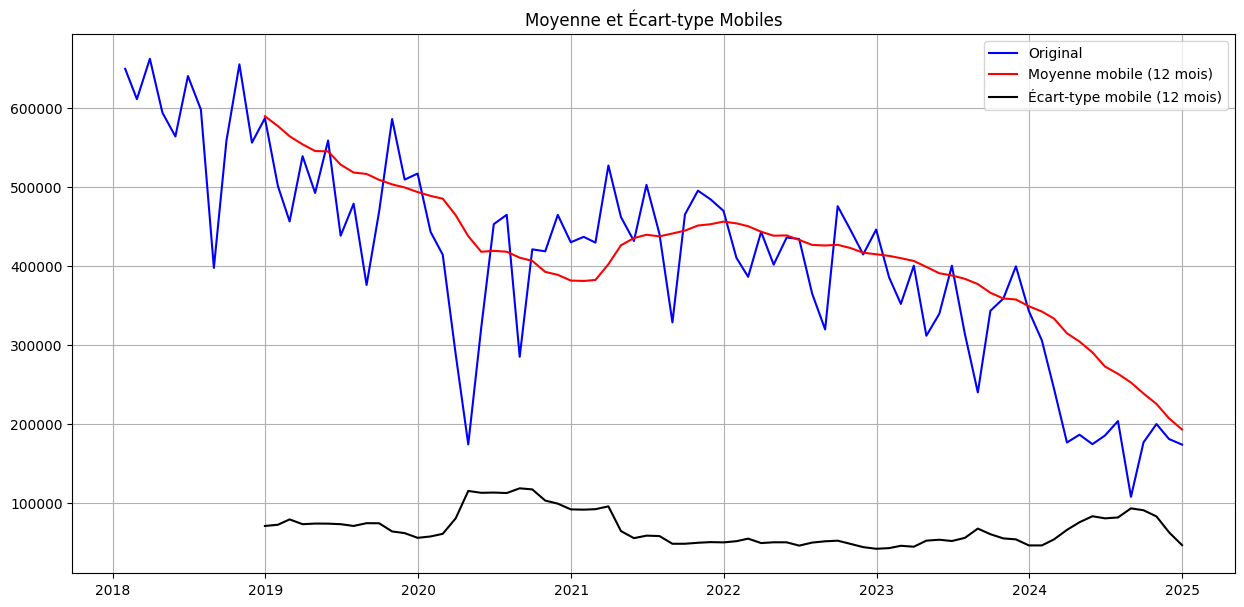

In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Test de stationnarité (test Augmented Dickey-Fuller)
def test_stationarity(timeseries):
    print("Résultats du test de Dickey-Fuller augmenté:")
    dftest = adfuller(timeseries.dropna(), autolag='AIC')  # AIC pour sélection automatique du lag
    dfoutput = pd.Series(dftest[0:4], index=['Statistique de test', 'p-value', 
                                            'Lags utilisés', 'Nombre d\'observations'])
    for key, value in dftest[4].items():
        dfoutput['Valeur critique (%s)' % key] = value
    print(dfoutput)
    
    # Interprétation
    print(f"\nInterprétation:")
    if dfoutput['p-value'] < 0.05:
        print("→ La série est STATIONNAIRE (on rejette H0)")
    else:
        print("→ La série est NON STATIONNAIRE (on ne peut pas rejeter H0)")

# Appliquer le test de stationnarité
print("Test de stationnarité sur la série originale:")
test_stationarity(ts_data['total_remboursement'])

# Visualisation ACF et PACF pour identifier l'ordre des différenciations nécessaires
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(ts_data['total_remboursement'].dropna(), lags=40, ax=ax1)
ax1.set_title('Fonction d\'Auto-Corrélation (ACF)')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

plot_pacf(ts_data['total_remboursement'].dropna(), lags=40, ax=ax2)
ax2.set_title('Fonction d\'Auto-Corrélation Partielle (PACF)')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Visualisation rolling statistics pour une analyse visuelle
plt.figure(figsize=(15, 7))
rolling_mean = ts_data['total_remboursement'].rolling(window=12).mean()
rolling_std = ts_data['total_remboursement'].rolling(window=12).std()

plt.plot(ts_data['total_remboursement'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='Moyenne mobile (12 mois)')
plt.plot(rolling_std, color='black', label='Écart-type mobile (12 mois)')
plt.legend(loc='best')
plt.title('Moyenne et Écart-type Mobiles')
plt.grid(True)
plt.show()

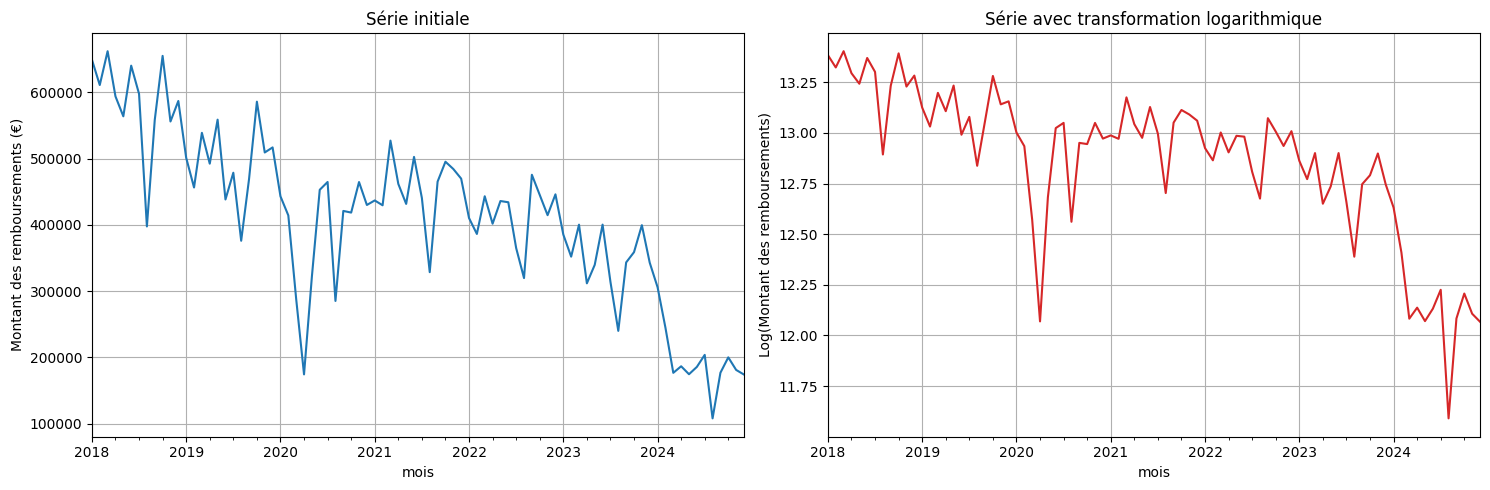

Test de stationnarité ADF pour série transformée logarithmiquement:
Statistique ADF: -1.2586
p-value: 0.6479
Lags utilisés: 2
Nombre d'observations: 81
Valeurs critiques:
   1%: -3.5138
   5%: -2.8979
   10%: -2.5862
→ La série est NON STATIONNAIRE (on ne peut pas rejeter H0)
--------------------------------------------------
Test de stationnarité ADF pour série transformée logarithmiquement et différenciée:
Statistique ADF: -7.5540
p-value: 0.0000
Lags utilisés: 2
Nombre d'observations: 80
Valeurs critiques:
   1%: -3.5149
   5%: -2.8984
   10%: -2.5864
→ La série est STATIONNAIRE (on rejette H0)
--------------------------------------------------


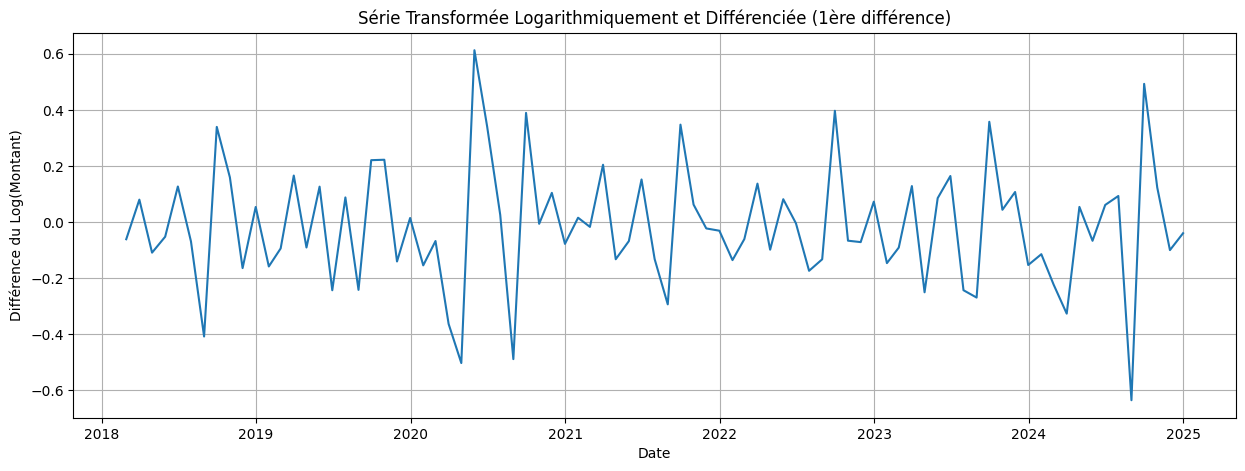

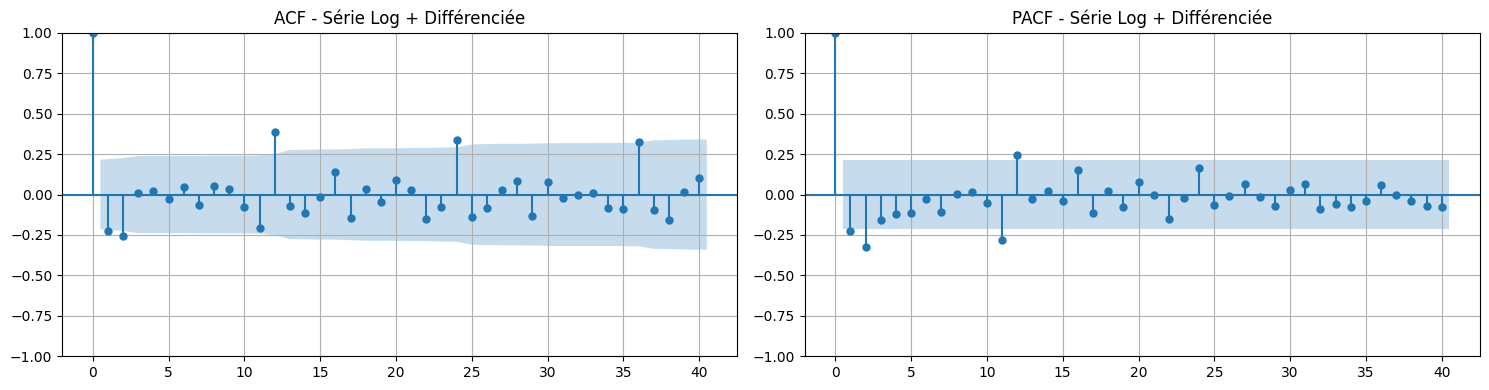

Test de stationnarité ADF pour série transformée avec différenciation saisonnière (lag=12):
Statistique ADF: -3.0045
p-value: 0.0345
Lags utilisés: 0
Nombre d'observations: 71
Valeurs critiques:
   1%: -3.5260
   5%: -2.9032
   10%: -2.5890
→ La série est STATIONNAIRE (on rejette H0)
--------------------------------------------------
Test de stationnarité ADF pour série transformée avec double différenciation:
Statistique ADF: -3.0175
p-value: 0.0333
Lags utilisés: 11
Nombre d'observations: 59
Valeurs critiques:
   1%: -3.5464
   5%: -2.9119
   10%: -2.5937
→ La série est STATIONNAIRE (on rejette H0)
--------------------------------------------------


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Transformation logarithmique
ts_log = np.log(ts_data['total_remboursement'])

# Création de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Série originale
ts_data['total_remboursement'].plot(title="Série initiale", color="tab:blue", ax=ax1, legend=False)
ax1.set_ylabel('Montant des remboursements (€)')
ax1.grid(True)

# Série avec transformation logarithmique
ts_log.plot(title="Série avec transformation logarithmique", color="tab:red", ax=ax2, legend=False)
ax2.set_ylabel('Log(Montant des remboursements)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Fonction pour le test ADF
def test_stationarity_adf(timeseries, name="Série"):
    print(f"Test de stationnarité ADF pour {name}:")
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'Statistique ADF: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Lags utilisés: {result[2]}')
    print(f'Nombre d\'observations: {result[3]}')
    print('Valeurs critiques:')
    for key, value in result[4].items():
        print(f'   {key}: {value:.4f}')
    
    # Interprétation
    if result[1] <= 0.05:
        print("→ La série est STATIONNAIRE (on rejette H0)")
    else:
        print("→ La série est NON STATIONNAIRE (on ne peut pas rejeter H0)")
    print("-" * 50)

# Test de stationnarité ADF sur la série transformée logarithmiquement
test_stationarity_adf(ts_log, "série transformée logarithmiquement")

# Différenciation de la série transformée logarithmiquement
ts_log_diff = ts_log.diff().dropna()

# Test de stationnarité ADF sur la série transformée et différenciée
test_stationarity_adf(ts_log_diff, "série transformée logarithmiquement et différenciée")

# Visualisation de la série transformée et différenciée
plt.figure(figsize=(15, 5))
plt.plot(ts_log_diff)
plt.title('Série Transformée Logarithmiquement et Différenciée (1ère différence)')
plt.xlabel('Date')
plt.ylabel('Différence du Log(Montant)')
plt.grid(True)
plt.show()

# ACF et PACF de la série transformée et différenciée
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

plot_acf(ts_log_diff, lags=40, ax=ax1)
ax1.set_title('ACF - Série Log + Différenciée')
ax1.grid(True)

plot_pacf(ts_log_diff, lags=40, ax=ax2)
ax2.set_title('PACF - Série Log + Différenciée')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Analyse des patterns saisonniers sur la série transformée
ts_log_seasonal_diff = ts_log.diff(12).dropna()

# Test de stationnarité ADF sur la série avec différenciation saisonnière
test_stationarity_adf(ts_log_seasonal_diff, "série transformée avec différenciation saisonnière (lag=12)")

# Test avec double différenciation (régulière + saisonnière)
ts_log_diff_seasonal = ts_log.diff().diff(12).dropna()
test_stationarity_adf(ts_log_diff_seasonal, "série transformée avec double différenciation")

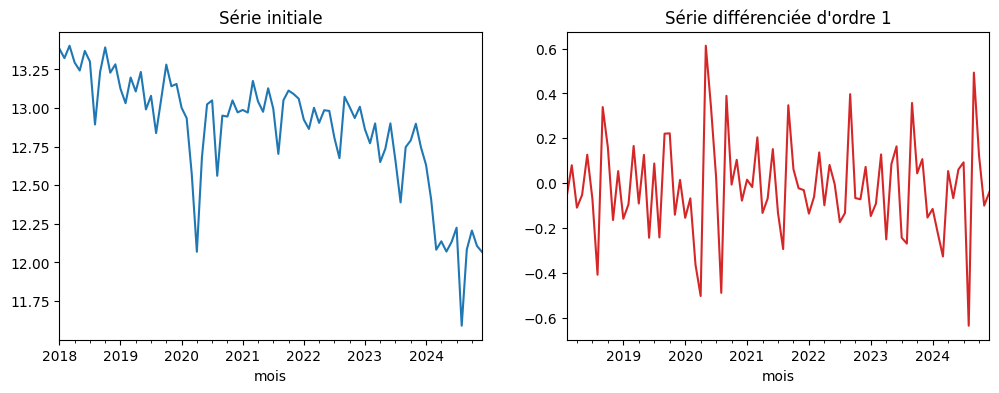

-------------Résultats du Test Dickey Fuller-------------
ADF Statistic: -7.553969
p-value: 0.000000
La série est stationnaire.


In [9]:
# Différenciation de première ordre
ts_diff = ts_log.diff() # Différenciation de première ordre et suppression des valeurs manquantes résultantes

ts_diff = ts_log.diff().dropna()

# Création de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Tracé de la série initiale et différenciée
ts_log.plot(title="Série initiale",color="tab:blue", ax=ax1)

ts_diff.plot(title="Série différenciée d'ordre 1", color="tab:red", ax=ax2)

plt.show() 

print('-------------Résultats du Test Dickey Fuller-------------')

result = adfuller(ts_diff, autolag='AIC')

# Affiche la statistique du test et la valeur p
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpréter les résultats
if result[1] < 0.05:
    print('La série est stationnaire.')
else:
    print('La série est non-stationnaire.')

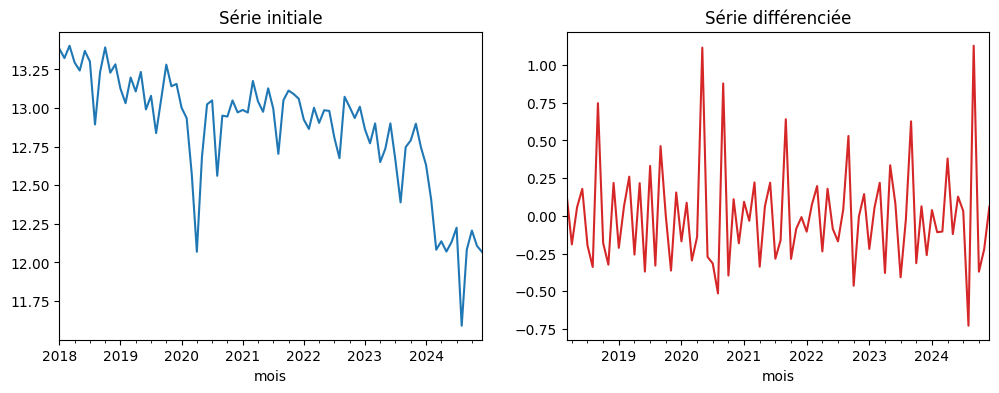

-------------Résultats du Test Dickey Fuller-------------
ADF Statistic: -5.635820
p-value: 0.000001
La série est stationnaire.


In [10]:
# Différenciation de deuxième ordre et suppression des valeurs manquantes résultantes
ts_diff2 = ts_diff.diff().dropna()

# Création de sous-graphiques
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Tracé de la série initiale et différenciée
ts_log.plot(title="Série initiale",color="tab:blue", ax=ax1)

ts_diff2.plot(title="Série différenciée", color="tab:red", ax=ax2)

plt.show()

print('-------------Résultats du Test Dickey Fuller-------------')

result = adfuller(ts_diff2, autolag='AIC')

# Affiche la statistique du test et la valeur p
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpréter les résultats
if result[1] < 0.05:
    print('La série est stationnaire.')
else:
    print('La série est non-stationnaire.')

Taille de l'échantillon: 82
Nombre maximum de lags autorisé: 41


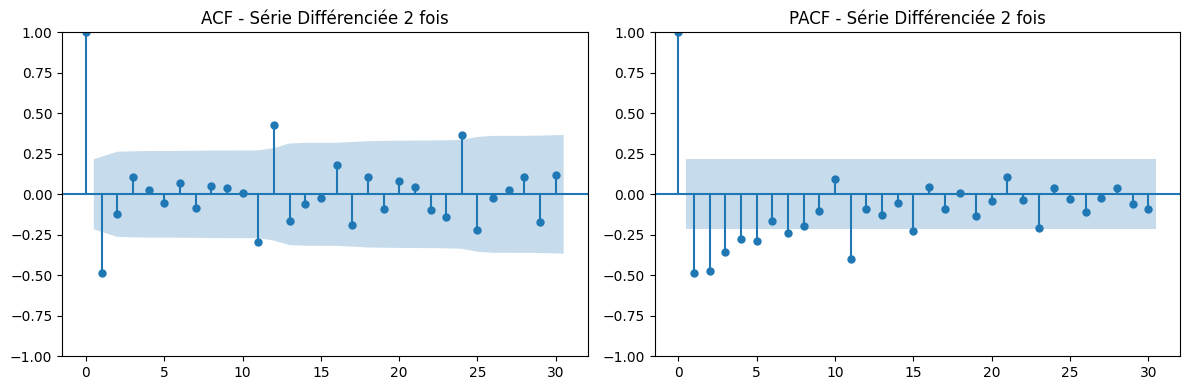

In [11]:
# Création d'une figure avec deux sous-graphiques
fig, (ax1, ax2)= plt.subplots(1,2, figsize=(12, 4))

# Déterminer le nombre maximum de lags possible (50% de la taille de l'échantillon)
max_lags = len(ts_diff2) // 2
print(f"Taille de l'échantillon: {len(ts_diff2)}")
print(f"Nombre maximum de lags autorisé: {max_lags}")

# Tracé de la fonction d'autocorrélation (ACF) pour la série différenciée deux fois
plot_acf(ts_diff2, lags=min(30, max_lags), ax=ax1)  # Utiliser min(30, max_lags)
ax1.set_title('ACF - Série Différenciée 2 fois')

# Tracé de la fonction d'autocorrélation partielle (PACF) pour la série différenciée deux fois
plot_pacf(ts_diff2, lags=min(30, max_lags), ax=ax2)  # Utiliser min(30, max_lags)
ax2.set_title('PACF - Série Différenciée 2 fois')

plt.tight_layout()
plt.show()

c:\Users\zme.IGA\OneDrive - IGA TUNISIE\Bureau\mp\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\zme.IGA\OneDrive - IGA TUNISIE\Bureau\mp\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                SARIMAX Results                                
Dep. Variable:     total_remboursement   No. Observations:                   67
Model:                  ARIMA(2, 2, 2)   Log Likelihood                  15.752
Date:                 Wed, 26 Nov 2025   AIC                            -21.505
Time:                         09:23:10   BIC                            -10.633
Sample:                     01-31-2018   HQIC                           -17.215
                          - 07-31-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3082      0.167      1.843      0.065      -0.020       0.636
ar.L2         -0.1973      0.136     -1.456      0.146      -0.463       0.068
ma.L1         -1.7528     18.258     -0.096 

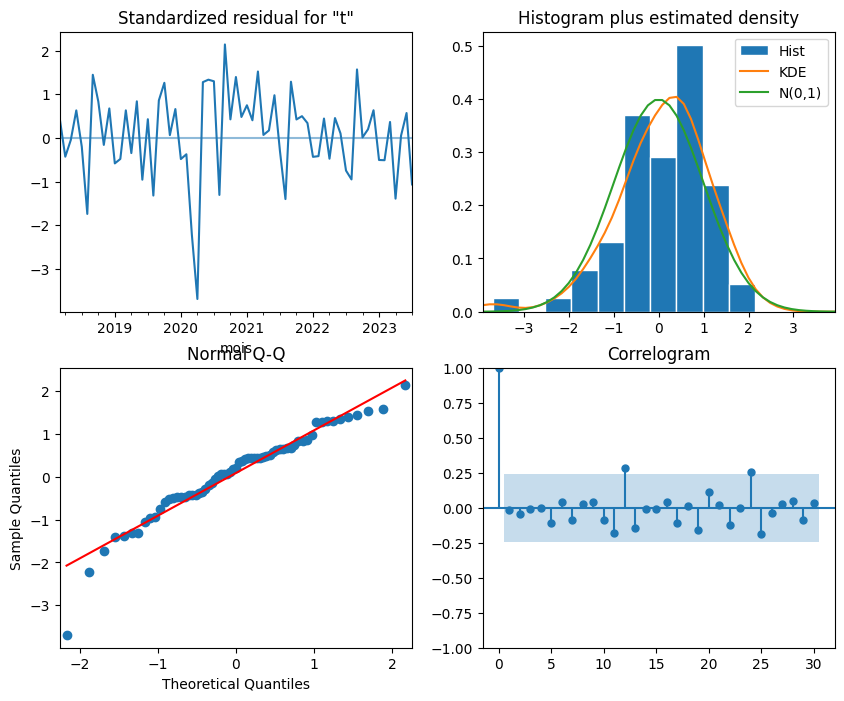

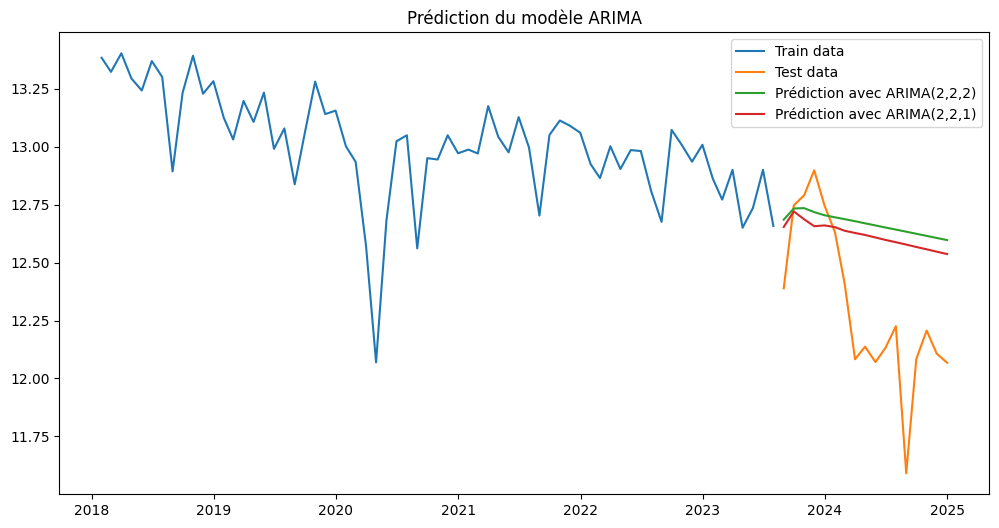

In [12]:
# On va modéliser la série ts_log (non-stationnaire)
# On divise les données en ensembles de test et d'entraînement

size = int(len(ts_log) * 0.8)
train_ts = ts_log.iloc[:size]     # 80% données d'entraînement
test_ts = ts_log.iloc[size:]      # 20% données de test

# Il faut ajuster le modèle aux données d'entraînement train_ts
model1 = ARIMA(train_ts, order=(2, 2, 2))
model1_fit = model1.fit()
print(model1_fit.summary())

# Il faut ajuster le modèle aux données d'entraînement train_ts
model2 = ARIMA(train_ts, order=(2, 2, 1))
model2_fit = model2.fit()
print(model2_fit.summary())

# Diagnostic du résidu pour le modèle ARIMA(2,2,2):
model1_fit.plot_diagnostics(figsize=(10, 8), lags=30)
plt.show()

start_index = test_ts.index[0]
end_index = test_ts.index[-1]
prediction1 = model1_fit.predict(start=start_index, end=end_index)
prediction2 = model2_fit.predict(start=start_index, end=end_index)  

plt.figure(figsize=(12, 6))
plt.plot(train_ts, label='Train data')
plt.plot(test_ts, label='Test data')
plt.plot(prediction1, label='Prédiction avec ARIMA(2,2,2)')
plt.plot(prediction2, label='Prédiction avec ARIMA(2,2,1)')
plt.title('Prédiction du modèle ARIMA')
plt.legend()
plt.show()

In [13]:
# On va appliquer une différentiation saisonnière pour éliminer la saisonalité
ts_diff_S = ts_diff.diff(12).dropna()

In [14]:
ts_diff_S

mois
2019-02-28   -0.032790
2019-03-31    0.085960
2019-04-30    0.018315
2019-05-31    0.178495
2019-06-30   -0.369871
                ...   
2024-08-31   -0.365937
2024-09-30    0.135214
2024-10-31    0.079116
2024-11-30   -0.207135
2024-12-31    0.113286
Freq: ME, Name: total_remboursement, Length: 71, dtype: float64

In [15]:
print('-------------Résultats du Test Dickey Fuller-------------')

result = adfuller(ts_diff_S, autolag='AIC')

# Affiche la statistique du test et la valeur p
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Interpréter les résultats
if result[1] < 0.05:
    print('La série est stationnaire.')
else:
    print('La série est non-stationnaire.')

-------------Résultats du Test Dickey Fuller-------------
ADF Statistic: -3.017490
p-value: 0.033293
La série est stationnaire.


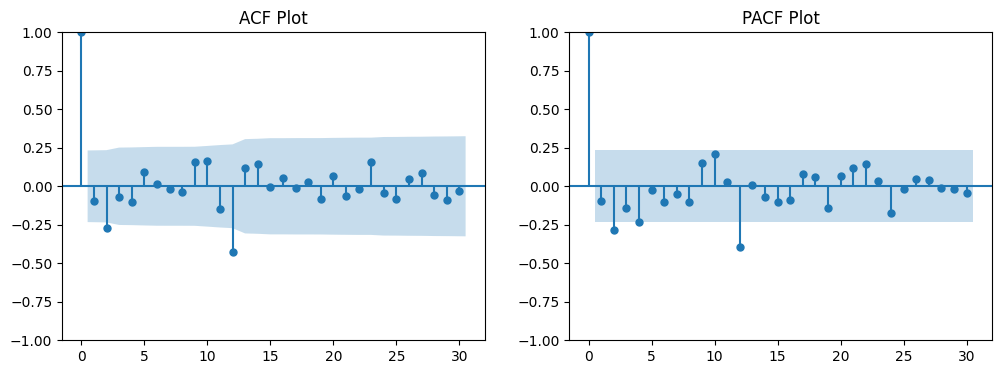

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# ACF Plot
plot_acf(ts_diff_S, lags=30, ax=ax1)
ax1.set_title('ACF Plot')

# PACF Plot
plot_pacf(ts_diff_S, lags=30, ax=ax2)
ax2.set_title('PACF Plot')

plt.show()

In [17]:
#On va ajuster le modèle SARIMA(2,1,2)(1,1,1,12)

model_S1 = ARIMA(train_ts, order=(2,1,2), seasonal_order=(1,1,1,12))
model_S1_fit = model_S1.fit()
print(model_S1_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_remboursement   No. Observations:                   67
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                  21.438
Date:                            Wed, 26 Nov 2025   AIC                            -28.875
Time:                                    09:24:02   BIC                            -14.952
Sample:                                01-31-2018   HQIC                           -23.506
                                     - 07-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6763      0.612      1.106      0.269      -0.523       1.875
ar.L2         -0.3758      0.390   

c:\Users\zme.IGA\OneDrive - IGA TUNISIE\Bureau\mp\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


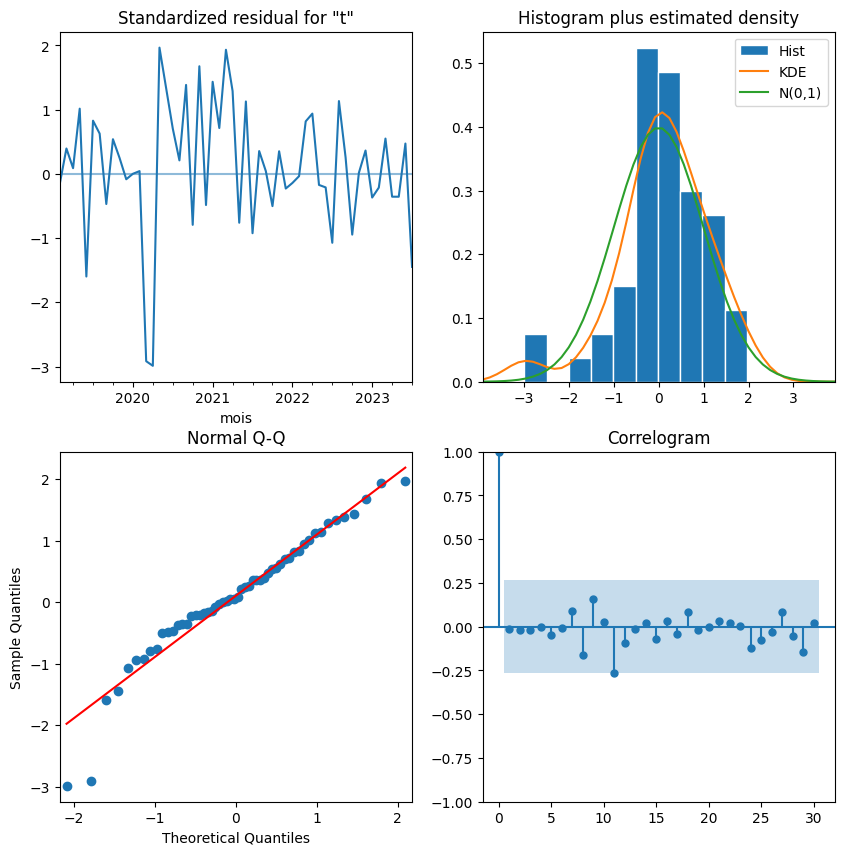

In [18]:
# Diagnostic du résidu pour le modèle (SARIMA(2, 1, 2)(1, 1, 1, 12))
model_S1_fit.plot_diagnostics(figsize=(10, 10), lags=30)
plt.show()

In [19]:
model_S2 = ARIMA(train_ts, order=(0,1,0), seasonal_order=(0,1,1,12))
model_S2_fit = model_S2.fit()
print(model_S2_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                total_remboursement   No. Observations:                   67
Model:             ARIMA(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  16.595
Date:                            Wed, 26 Nov 2025   AIC                            -29.191
Time:                                    09:24:19   BIC                            -25.213
Sample:                                01-31-2018   HQIC                           -27.656
                                     - 07-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9860      6.804     -0.145      0.885     -14.321      12.349
sigma2         0.0220      0.148   

In [21]:
lb_test = acorr_ljungbox(model_S2_fit.resid, lags=30, return_df=True)

# Afficher les résultats du test
if lb_test.iloc[0, 1] < 0.05:
    print("Le test de Ljung-Box montre que les résidus ne sont pas indépendants.")
    print("P-value :", lb_test.iloc[0, 1])
else:
    print("Le test de Ljung-Box montre que les résidus sont indépendants.")
    print("P-value :", lb_test.iloc[0, 1])

Le test de Ljung-Box montre que les résidus sont indépendants.
P-value : 0.9834106591514022


In [22]:

lb_test = acorr_ljungbox(model_S1_fit.resid, lags=30, return_df=True)

# Afficher les résultats du test
if lb_test.iloc[0, 1] < 0.05:
    print("Le test de Ljung-Box montre que les résidus ne sont pas indépendants.")
    print("P-value :", lb_test.iloc[0, 1])
else:
    print("Le test de Ljung-Box montre que les résidus sont indépendants.")
    print("P-value :", lb_test.iloc[0, 1])

Le test de Ljung-Box montre que les résidus sont indépendants.
P-value : 0.9862068592781753


In [23]:
# Recherche manuelle des meilleurs paramètres SARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools
import warnings
warnings.filterwarnings('ignore')

# Paramètres à tester basés sur notre analyse ACF/PACF
p_range = range(0, 3)  # AR terms
d_range = [1]          # Différenciation (déjà déterminée)
q_range = range(0, 3)  # MA terms
P_range = range(0, 2)  # Seasonal AR
D_range = [1]          # Seasonal differentiation  
Q_range = range(0, 2)  # Seasonal MA
s = 12                 # Saisonnalité mensuelle

best_aic = float('inf')
best_params = None
best_model_fit = None

print("Recherche des meilleurs paramètres SARIMA...")

for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                try:
                    # Utiliser d=1 et D=1 comme déterminé précédemment
                    model = SARIMAX(train_ts, 
                                  order=(p, 1, q), 
                                  seasonal_order=(P, 1, Q, s))
                    model_fit = model.fit(disp=False)
                    
                    if model_fit.aic < best_aic:
                        best_aic = model_fit.aic
                        best_params = (p, 1, q, P, 1, Q, s)
                        best_model_fit = model_fit
                        
                    print(f"SARIMA({p},1,{q})({P},1,{Q},{s}) - AIC: {model_fit.aic:.2f}")
                    
                except:
                    continue

print(f"\nMeilleur modèle: SARIMA{best_params}")
print(f"Meilleur AIC: {best_aic:.2f}")

# Afficher le résumé du meilleur modèle
print("\nRésumé du meilleur modèle:")
print(best_model_fit.summary())

Recherche des meilleurs paramètres SARIMA...
SARIMA(0,1,0)(0,1,0,12) - AIC: -5.28
SARIMA(0,1,0)(0,1,1,12) - AIC: -29.19
SARIMA(0,1,0)(1,1,0,12) - AIC: -17.35
SARIMA(0,1,0)(1,1,1,12) - AIC: -27.55
SARIMA(0,1,1)(0,1,0,12) - AIC: -3.31
SARIMA(0,1,1)(0,1,1,12) - AIC: -27.79
SARIMA(0,1,1)(1,1,0,12) - AIC: -15.48
SARIMA(0,1,1)(1,1,1,12) - AIC: -26.42
SARIMA(0,1,2)(0,1,0,12) - AIC: -9.83
SARIMA(0,1,2)(0,1,1,12) - AIC: -33.54
SARIMA(0,1,2)(1,1,0,12) - AIC: -21.52
SARIMA(0,1,2)(1,1,1,12) - AIC: -31.80
SARIMA(1,1,0)(0,1,0,12) - AIC: -3.29
SARIMA(1,1,0)(0,1,1,12) - AIC: -27.41
SARIMA(1,1,0)(1,1,0,12) - AIC: -15.40
SARIMA(1,1,0)(1,1,1,12) - AIC: -25.85
SARIMA(1,1,1)(0,1,0,12) - AIC: -9.22
SARIMA(1,1,1)(0,1,1,12) - AIC: -31.81
SARIMA(1,1,1)(1,1,0,12) - AIC: -19.84
SARIMA(1,1,1)(1,1,1,12) - AIC: -30.17
SARIMA(1,1,2)(0,1,0,12) - AIC: -10.35
SARIMA(1,1,2)(0,1,1,12) - AIC: -32.05
SARIMA(1,1,2)(1,1,0,12) - AIC: -20.48
SARIMA(1,1,2)(1,1,1,12) - AIC: -30.23
SARIMA(2,1,0)(0,1,0,12) - AIC: -7.32
SARIMA(2,1,

=== RE-ENTRAÎNEMENT DU MODÈLE AVEC TOUTES LES DONNÉES ===
Modèle ré-entraîné avec toutes les données jusqu'en 2024
Dernière date des données: 2024-12-31 00:00:00
Prédictions de 2025-01-31 00:00:00 à 2025-12-31 00:00:00

=== PRÉDICTIONS POUR 2025 ===
January 2025: 155,204.21 €
February 2025: 142,206.71 €
March 2025: 142,770.44 €
April 2025: 121,538.56 €
May 2025: 134,712.37 €
June 2025: 146,762.57 €
July 2025: 138,424.59 €
August 2025: 97,316.81 €
September 2025: 139,999.60 €
October 2025: 151,222.69 €
November 2025: 145,188.36 €
December 2025: 141,942.38 €


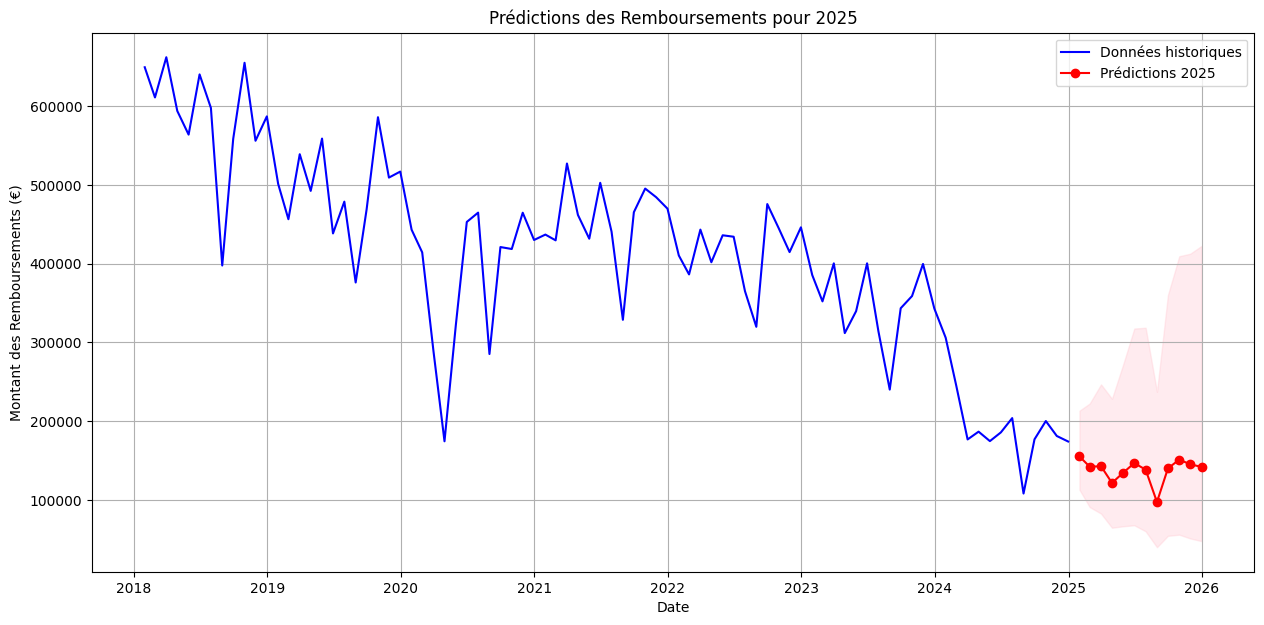


=== STATISTIQUES 2025 ===
Moyenne mensuelle: 138,107.44 €
Total annuel 2025: 1,657,289.30 €
Minimum mensuel: 97,316.81 €
Maximum mensuel: 155,204.21 €
Intervalle de confiance: 63,624.21 € à 295,875.39 €


In [24]:
# CORRECTION : Utiliser toutes les données pour l'entraînement final
print("=== RE-ENTRAÎNEMENT DU MODÈLE AVEC TOUTES LES DONNÉES ===")

# Utiliser TOUTES les données pour l'entraînement final
final_model = SARIMAX(ts_log,  # Utiliser ts_log au lieu de train_ts
                     order=(0, 1, 0), 
                     seasonal_order=(0, 1, 1, 12))
final_model_fit = final_model.fit(disp=False)

print("Modèle ré-entraîné avec toutes les données jusqu'en 2024")
print(f"Dernière date des données: {ts_log.index[-1]}")

# Prédictions pour 2025 (12 mois)
forecast_steps = 12
forecast = final_model_fit.get_forecast(steps=forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

print(f"Prédictions de {forecast_values.index[0]} à {forecast_values.index[-1]}")

# Conversion des prédictions en valeurs originales
forecast_original = np.exp(forecast_values)

print("\n=== PRÉDICTIONS POUR 2025 ===")
for date, value in zip(forecast_original.index, forecast_original):
    print(f"{date.strftime('%B %Y')}: {value:,.2f} €")

# Visualisation
plt.figure(figsize=(15, 7))
plt.plot(ts_data.index, ts_data['total_remboursement'], label='Données historiques', color='blue')
plt.plot(forecast_original.index, forecast_original.values, label='Prédictions 2025', color='red', marker='o')
plt.fill_between(forecast_ci.index, np.exp(forecast_ci.iloc[:, 0]), np.exp(forecast_ci.iloc[:, 1]), color='pink', alpha=0.3)
plt.title('Prédictions des Remboursements pour 2025')
plt.xlabel('Date')
plt.ylabel('Montant des Remboursements (€)')
plt.legend()
plt.grid(True)
plt.show()

# Statistiques 2025
print(f"\n=== STATISTIQUES 2025 ===")
print(f"Moyenne mensuelle: {forecast_original.mean():,.2f} €")
print(f"Total annuel 2025: {forecast_original.sum():,.2f} €")
print(f"Minimum mensuel: {forecast_original.min():,.2f} €")
print(f"Maximum mensuel: {forecast_original.max():,.2f} €")
print(f"Intervalle de confiance: {np.exp(forecast_ci.iloc[:, 0].mean()):,.2f} € à {np.exp(forecast_ci.iloc[:, 1].mean()):,.2f} €")

In [26]:
# === SAUVEGARDE DES PRÉVISIONS DANS UN FICHIER EXCEL ===

import pandas as pd

# Créer un DataFrame propre avec toutes les infos
df_export = pd.DataFrame({
    'date': forecast_original.index,
    'prediction': forecast_original.values,
    'lower_ci': np.exp(forecast_ci.iloc[:, 0].values),
    'upper_ci': np.exp(forecast_ci.iloc[:, 1].values)
})

# Mettre la date au bon format
df_export['date'] = df_export['date'].dt.strftime('%Y-%m-%d')

# Chemin de sortie (dans ton dossier mp)
output_path = "previsions_2025.xlsx"

# Export Excel
df_export.to_excel(output_path, index=False)

print(f"📁 Fichier Excel généré avec succès : {output_path}")


📁 Fichier Excel généré avec succès : previsions_2025.xlsx
